## Instalando Tensorflow

In [2]:
# Instalação das bibliotecas necessárias
%pip install tensorflow
%pip install gensim
%pip install nltk
%pip install seaborn
%pip install keras
%pip install --upgrade tensorflow
%pip install scikeras[tensorflow]


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install --upgrade tensorflow

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score
from gensim.models import Word2Vec
from nltk.stem import RSLPStemmer
import re
import os
import unicodedata
from zipfile import ZipFile
import nltk
import xml.etree.ElementTree as ET
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Carregamento dos Dados e Pré-processamento

### Carregar e descompactar os arquivos

In [ ]:
def criar_diretorios(caminho):
    # Extrai o diretório do caminho fornecido
    diretorio = os.path.dirname(caminho)
    
    # Cria os diretórios se eles não existirem
    if not os.path.exists(diretorio):
        os.makedirs(diretorio)
        print(f"{diretorio} criado com sucesso")
    else:
        print(f"{diretorio} já existe")
        
    return caminho

In [5]:


def unzip(path, pathFolder):
    """
    Descompacta a base de dados de notícias.
    
    Args:
    path (str): Caminho para o arquivo zip.
    pathFolder (str): Caminho para a pasta onde os arquivos serão extraídos.
    """
    # Abre o arquivo zip para leitura
    with ZipFile(path, 'r') as z:
        # Verifica se a pasta de destino já existe
        if not os.path.isdir(pathFolder):
            # Extrai todos os arquivos para a pasta de destino
            z.extractall(pathFolder)
        else:
            print("Os arquivos já foram descompactados.")

# Caminho dos arquivos extraídos do Kaggle
path_dataset = r'af_inteligencia_artificial\files\classificao-de-notcias.zip'
path_db = r'db'

# Caminho dos arquivos que serão utilizados para a atividade
path_train = r'db\arquivos_competicao\arquivos_competicao\train.csv'
path_pred = r'db\arquivos_competicao\arquivos_competicao\test.csv'
path_news = r'db\arquivos_competicao\arquivos_competicao\news'

# Antes de descompactar os arquivos, valida se já foram descompactados antes
if not os.path.isdir(path_news):
    # Verifica se o arquivo zip existe
    if os.path.isfile(path_dataset):
        unzip(path_dataset, path_db)
    else:
        print(f"Arquivo não encontrado: {path_dataset}")
else:
    print("Os arquivos já foram descompactados.")



Os arquivos já foram descompactados.


# Carregamento dos dados de treino e teste
Carregamos os arquivos CSV de treino e teste, ordenando pela coluna ID.


In [6]:
# Carregamento dos dados de treino e teste
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_pred)

# Ordena os dataframes df_train e df_test pela coluna ID
df_train = df_train.sort_values(['ID'])
df_test = df_test.sort_values(['ID'])

# Extração dos dados XML

- A função extract_xml_text extrai o texto e o título dos arquivos XML. Atualizamos os dataframes df_train e df_test com esses dados.


In [7]:
# Definindo a função para extração dos dados XML 
def extract_xml_text(path_xml):
    """
    Extrai o texto e o título dos arquivos XML.

    Args:
    path_xml (str): Caminho para o arquivo XML.

    Returns:
    tuple: Contém o título e o texto do arquivo XML.
    """
    tree = ET.parse(path_xml)
    root = tree.getroot()
    
    # Extraindo o título
    headline = root.find('headline').text if root.find('headline') is not None else ''
    
    # Extraindo os parágrafos
    paragraphs = root.findall('.//p')
    text = ' '.join([p.text for p in paragraphs if p.text is not None])

    return headline, text

# Processando os arquivos XML e atualizando o dataframe df_train
for idx in df_train.index:
    file = df_train.at[idx, 'ID']
    path_xml = os.path.join(path_news, file)
    titulo, texto = extract_xml_text(path_xml)
    df_train.at[idx, 'TITULO'] = titulo
    df_train.at[idx, 'TEXTO'] = texto

# Reorganiza o dataframe com as colunas desejadas
df_train = df_train[['ID', 'TITULO', 'TEXTO', 'Class']]

# Processando os arquivos XML e atualizando o dataframe df_test
for idx in df_test.index:
    file = df_test.at[idx, 'ID']
    path_xml = os.path.join(path_news, file)
    titulo, texto = extract_xml_text(path_xml)
    df_test.at[idx, 'TITULO'] = titulo
    df_test.at[idx, 'TEXTO'] = texto

# Reorganiza o dataframe com as colunas desejadas
df_teste = df_test[['ID', 'TITULO', 'TEXTO']]


C:\Users\Lucas\AppData\Local\Temp\ipykernel_14556\271242300.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value ' FUTURO OT DEZ/96 CAI PARA 102,23 CONTRA 102,52[PT] ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_train.at[idx, 'TITULO'] = titulo
C:\Users\Lucas\AppData\Local\Temp\ipykernel_14556\271242300.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value ' *Futuro (BDPOTZ6)Dez/96 102,23 vs 102,52 no fecho anterior *Futuro Bono Dez/96 (MFFZ6)106,95 vs 107,31 no fecho anterior   - Lisboa Editorial, 351-1-3150035   (c) Reuters Limited 1996. ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_train.at[idx, 'TEXTO'] = texto
C:\Users\Lucas\AppData\Local\Temp\ipykernel_14556\271242300.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated an

# Definindo funçãio de tratamento de texto

utilizando função de tratamento de texto para remover tags html
- Removendo stopwords com `nltk.corpus.stopwords.words`
- Utilizando método de stemização para extrair os radicais das palavras contidas nas mensagens de texto com `stemmer_method = RSLPStemmer()`

In [9]:
def preprocessing_portuguese(text, stemming=False, stopwords=False):
    text = text.lower()
    nfkd_form = unicodedata.normalize('NFKD', text)
    text = u"".join([c for c in nfkd_form if not unicodedata.combining(c)])
    text = re.sub('<[^<>]+>', " ", text)
    text = re.sub('(http|https)://[^\s]*', "<URL>", text)
    text = re.sub('[^\s]+@[^\s]+', "<EMAIL>", text)
    text = re.sub('[^A-Za-z0-9]+', " ", text)
    text = re.sub('[0-9]+.[0-9]+', "NUMERO", text)
    text = re.sub('[0-9]+,[0-9]+', "NUMERO", text)
    text = re.sub('[0-9]+', "NUMERO", text)
    text = ' '.join(text.split())
    words = text.split()[0:200]
    if stopwords:
        words = [w for w in words if not w in nltk.corpus.stopwords.words('portuguese')]
    if stemming:
        stemmer_method = RSLPStemmer()
        words = [stemmer_method.stem(w) for w in words]
    words = [w for w in words if len(w) > 1]
    text = " ".join(words)
    return text

# Aplicando a função e enconding para campo target

- utiliando função  preprocessing_portuguese definida anteriormente para tratar os campos de mensagens
- usando  labelEncoder para codificar o campo target para valores 0, 1, 2 e 3 com o intuito de representar os elementos da classe em números

In [10]:


df_train['TEXTO'] = df_train['TEXTO'].apply(lambda x: preprocessing_portuguese(x, stemming=True, stopwords=True))
df_test['TEXTO'] = df_test['TEXTO'].apply(lambda x: preprocessing_portuguese(x, stemming=True, stopwords=True))
le = LabelEncoder()
df_train['Class'] = le.fit_transform(df_train['Class'])


### Usando função de split para dividir o dataset de treino em campos de Data e Target

Usando 20 porcento do dataset como teste devido a distribução das classes no dataset de treino
(algumas classes possuem menos elementos do que as outras)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_train['TEXTO'],
                                                    df_train['Class'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df_train['Class'])


# Definindo newDatasetTrain

- esse vetor será utilizado para treinar as embeddings com nossa base de treino

In [12]:
newDatasetTrain = []
for msg in df_train['TEXTO']:
    newDatasetTrain.append( msg.split() )

print("Primeira mensagem de texto: ")
print( newDatasetTrain[0] )

Primeira mensagem de texto: 
['futur', 'bdpotznumer', 'dez', 'numer', 'numer', 'vs', 'numer', 'fech', 'anteri', 'futur', 'bon', 'dez', 'numer', 'mffznumer', 'numer', 'vs', 'numer', 'fech', 'anteri', 'lisbo', 'editor', 'numer', 'numer', 'reut', 'limited', 'numer']


In [13]:
dataset_train, dataset_test = X_train, X_test
Y_train, Y_test = y_train, y_test

In [14]:
print('Qtd. dados de treinamento: %d (%1.2f%%)' %(dataset_train.shape[0], (dataset_train.shape[0]/df_train.shape[0])*100) )
print('Qtd. de dados de teste: %d (%1.2f%%)' %(dataset_test.shape[0], (dataset_test.shape[0]/df_train.shape[0])*100) )

Qtd. dados de treinamento: 2224 (79.97%)
Qtd. de dados de teste: 557 (20.03%)


# Treinando modelo de embeddings

Treinamos o modelo de embeddings conforme os dados presentes na coluna de texto  em df_train que possui os dados tratados de train.csv
obtivemos um vocabulário relativamente enchuto, no entanto normalizar o dataset replicando notícias com classes de menor indicência obtivemos dificuldade
no treinamento do modelo. Ao que parece foi difícil lidar com o loss ao ajustar ao parâmetro, logo foi optado por utilizar os dados de treino da forma com
que foram passados mesmo.


- vector_size: Tamanho do vetor de embedding.
- window: Tamanho da janela de contexto.
- min_count: Frequência mínima para uma palavra ser considerada no treinamento.
- workers: Número de threads a serem usadas no treinamento.

In [15]:
from gensim.models import Word2Vec

# Treinando o modelo Word2Vec com suas mensagens de texto
embedding_model = Word2Vec(sentences=newDatasetTrain, vector_size=200, window=5, min_count=1, workers=4)

vocabSize = len(embedding_model.wv)
print("Tamanho do vocabulário do modelo: ", vocabSize)

Tamanho do vocabulário do modelo:  4599


## Obtendo vetores das palavras

### A função getDocvector converte os textos em vetores de embeddings usando o modelo Word2Vec.

- model: Modelo Word2Vec treinado.
- doc: Documento a ser convertido.
- maxLength: Comprimento máximo do documento.

In [20]:
def getDocvector(model, doc, maxLength = 200):
    """
    Obtem o vetor de cada palavra de um documento e calcula um vetor medio
    """

    ########################## COMPLETE O CÓDIGO AQUI  ########################

    firstWord = model.wv.index_to_key[0]
    dimEmbedding = model.wv[firstWord].shape[0]

    wordVecs = []

    for i in range(maxLength):

      vecZeros = np.zeros( dimEmbedding )
      wordVecs.append( vecZeros )

      if i<len(doc):

          try:
            wordVecs[i] = model.wv[ doc[i] ]
          except:
            pass

    # converte a lista em matriz
    wordVecs = np.array(wordVecs)

    ##########################################################################

    return wordVecs


In [21]:
X_train_array = []
for doc in X_train:
    X_train_array.append( getDocvector(embedding_model, doc.split(), maxLength = 200) )
    
X_test_array = []
for doc in X_test:
    X_test_array.append( getDocvector(embedding_model, doc.split(), maxLength = 200) )
    
X_train_array = np.array(X_train_array)
X_test_array = np.array(X_test_array)    
Y_train = np.array(Y_train)   
    
print("Dimensao de X_train: ", X_train_array.shape)
print("Dimensao de X_test: ", X_test_array.shape)




Dimensao de X_train:  (2224, 200, 200)
Dimensao de X_test:  (557, 200, 200)


# Treinamento do Modelo LSTM
### Configuração do Modelo LSTM
Configuramos um modelo LSTM com uma camada intermediária LSTM e uma camada de saída Dense com ativação softmax e sparse_categorical_crossentropy para problemas multiclasse.

- dimInput: Dimensão da entrada.
- units: Número de unidades na camada LSTM.
- activation: Função de ativação da camada Dense.

In [23]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


firstWord  = embedding_model.wv.index_to_key[0]
dimEmbedding = embedding_model.wv[firstWord].shape[0]

# defini a dimensão de entrada
dimInput = (200, dimEmbedding)

model = tf.keras.Sequential()

# camada intermediaria
model.add( tf.keras.layers.LSTM(
    units = 210,
    input_shape = dimInput,
    return_sequences = False
) )

# camada de saida
model.add( tf.keras.layers.Dense(
    units = 4, activation = "softmax"
)
)

optimizer = tf.keras.optimizers.Adam(
    learning_rate = 0.001
 )

model.compile( optimizer = optimizer,
               loss = "sparse_categorical_crossentropy",
               metrics = ["accuracy"]
             )


print("LSTM configurada com sucesso")

# summarize the model
print(model.summary())

LSTM configurada com sucesso


c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 210)            │       345,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           844 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,084 (1.32 MB)

 Trainable params: 346,084 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

None


# Treinamento do moelo

In [24]:

history = model.fit( X_train_array, Y_train,
                     epochs = 12,
                     validation_split = 0.2,
                     batch_size = 120)

Epoch 1/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 365ms/step - accuracy: 0.6221 - loss: 1.2364 - val_accuracy: 0.8135 - val_loss: 0.6538
Epoch 2/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - accuracy: 0.7827 - loss: 0.6426 - val_accuracy: 0.8180 - val_loss: 0.6253
Epoch 3/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 308ms/step - accuracy: 0.7889 - loss: 0.6653 - val_accuracy: 0.8180 - val_loss: 0.6098
Epoch 4/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.7996 - loss: 0.6421 - val_accuracy: 0.8157 - val_loss: 0.6355
Epoch 5/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 340ms/step - accuracy: 0.8025 - loss: 0.6420 - val_accuracy: 0.8157 - val_loss: 0.6146
Epoch 6/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step - accuracy: 0.7876 - loss: 0.6612 - val_accuracy: 0.8180 - val_loss: 0.6007
Epoch 7/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.8003 - loss: 0.6191 - val_accuracy: 0.8180 - val_loss: 0.6079
Epoch 8/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step - accuracy: 0.7885 - loss: 0.6388 - val_accuracy: 0.

## Avaliação do Modelo
Plot de curva de loss para validação do modelo

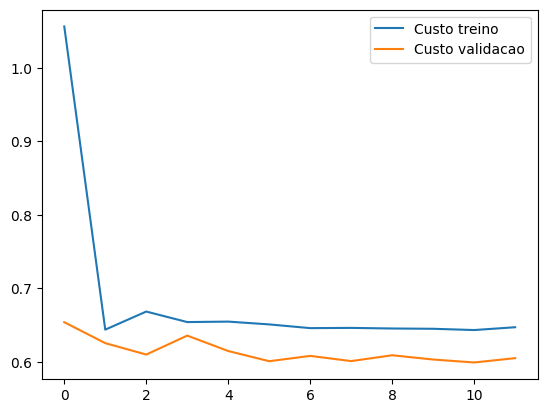

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame()
df['Custo treino'] = history.history['loss']
df['Custo validacao'] = history.history['val_loss']

df.plot()
plt.show()

### Codificação dos Textos com o Tokenizer BERT
Utilizamos o tokenizer BERT pré-treinado para codificar os textos de `X_train` e `X_test`. O tokenizer transforma o texto em IDs de tokens, aplicando truncamento e padding para garantir que todos os textos tenham o mesmo comprimento.

- **tokenizer**: Tokenizer BERT pré-treinado em português.
- **texts**: Lista de textos a serem codificados.
- **max_length**: Comprimento máximo dos textos após truncamento/padding.

In [ ]:
from transformers import BertTokenizer, TFBertModel

# Carregar o tokenizer e o modelo BERT pré-treinado em português
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
bert_model = TFBertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')


###  Obtenção das Embeddings BERT
Utilizamos o modelo BERT pré-treinado para obter as embeddings dos textos codificados. A função `get_embeddings_in_batches` processa os textos em lotes para obter as embeddings de forma eficiente.

- **input_ids**: IDs dos tokens codificados.
- **attention_mask**: Máscara de atenção para os tokens.
- **model**: Modelo BERT pré-treinado.
- **batch_size**: Tamanho dos lotes para processamento.



In [29]:
def encode_texts(texts, tokenizer, max_length=200):
    inputs = tokenizer(texts, return_tensors='tf', max_length=max_length, truncation=True, padding=True)
    return inputs['input_ids'], inputs['attention_mask']

X_train_encodings, X_train_masks = encode_texts(X_train.tolist(), tokenizer)
X_test_encodings, X_test_masks = encode_texts(X_test.tolist(), tokenizer)


In [30]:
import tensorflow as tf
# Função para obter embeddings em lotes
def get_embeddings_in_batches(input_ids, attention_mask, model, batch_size=32):
    num_samples = input_ids.shape[0]
    embeddings = []
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        batch_input_ids = input_ids[start:end]
        batch_attention_mask = attention_mask[start:end]
        outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
        embeddings.append(outputs.last_hidden_state)
    return tf.concat(embeddings, axis=0)


# Obter os embeddings BERT dos textos codificados

In [31]:
X_train_embeddings = get_embeddings_in_batches(X_train_encodings, X_train_masks, bert_model, batch_size=32)
X_test_embeddings = get_embeddings_in_batches(X_test_encodings, X_test_masks, bert_model, batch_size=32)
print("Dimensao de X_train_embeddings: ", X_train_embeddings.shape)
print("Dimensao de X_test_embeddings: ", X_test_embeddings.shape)

Dimensao de X_train_embeddings:  (2224, 200, 768)
Dimensao de X_test_embeddings:  (557, 200, 768)


### Configuração do Modelo LSTM
Configuramos um modelo LSTM com uma camada intermediária LSTM e uma camada de saída Dense com ativação softmax. O modelo é compilado usando o otimizador Adam e a função de perda `sparse_categorical_crossentropy`.

- **input_shape**: Forma da entrada para o modelo (dimensões das embeddings BERT).
- **units**: Número de unidades na camada LSTM.
- **activation**: Função de ativação da camada Dense de saída.

In [36]:
from tensorflow.keras import layers, Model
input_shape = X_train_embeddings.shape[1:]

input_layer = layers.Input(shape=input_shape)
lstm_layer = layers.LSTM(210, return_sequences=False)(input_layer)
output_layer = layers.Dense(4, activation='softmax')(lstm_layer)

model = Model(inputs=input_layer, outputs=output_layer)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print("LSTM configurada com sucesso")
print(model.summary())


LSTM configurada com sucesso


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 200, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 210)            │       822,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           844 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 823,204 (3.14 MB)

 Trainable params: 823,204 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

None


In [38]:
# Treinamento do modelo
history = model.fit(X_train_embeddings, Y_train,
                    epochs=5,
                    validation_split=0.2,
                    batch_size=120)

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 429ms/step - accuracy: 0.7254 - loss: 0.8012 - val_accuracy: 0.8652 - val_loss: 0.4874
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 440ms/step - accuracy: 0.8780 - loss: 0.4030 - val_accuracy: 0.8944 - val_loss: 0.2968
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 449ms/step - accuracy: 0.9049 - loss: 0.2824 - val_accuracy: 0.9079 - val_loss: 0.2591
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 411ms/step - accuracy: 0.9145 - loss: 0.2368 - val_accuracy: 0.8921 - val_loss: 0.2972
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 406ms/step - accuracy: 0.9174 - loss: 0.2515 - val_accuracy: 0.9146 - val_loss: 0.2434


### Avaliação do Modelo
A função `predicao` prevê as probabilidades para as classes, gera o relatório de desempenho e calcula o AUC. O desempenho do modelo é avaliado no conjunto de teste.

- **X_test**: Embeddings BERT dos textos de teste.
- **Y_test**: Labels dos textos de teste.
- **model**: Modelo treinado.

In [39]:
from sklearn.metrics import classification_report, roc_auc_score

def predicao(X_test, Y_test, model):
    # Prever as probabilidades para as classes
    y_pred_prob = model.predict(X_test)

    # Converter as probabilidades para as classes previstas
    y_pred = y_pred_prob.argmax(axis=1)

    # Gerar o relatório de desempenho
    desempenho = classification_report(Y_test, y_pred)

    # Calcular o AUC
    auc_score = roc_auc_score(Y_test, y_pred_prob, multi_class='ovr')

    return y_pred, desempenho, auc_score

##########################################################################

y_pred, desempenho, auc_score = predicao(X_test_embeddings, Y_test, model)

print(desempenho)
print(f"AUC: {auc_score:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.79      0.95      0.86       118
           2       1.00      0.11      0.20        18
           3       0.98      0.97      0.97       414

    accuracy                           0.93       557
   macro avg       0.69      0.51      0.51       557
weighted avg       0.92      0.93      0.91       557

AUC: 0.9422


c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

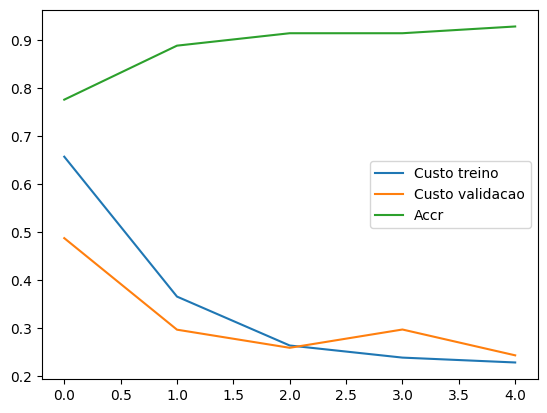

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame()
df['Custo treino'] = history.history['loss']
df['Custo validacao'] = history.history['val_loss']
df['Accr'] = history.history['accuracy']

df.plot()
plt.show()

Instalando bibliotecas para busca de hiperparâmetros. Inicialmente tentamos buscar por meio do algorítmo genético mas optamos por não utiliza-lo devido ao custo computacional (muita demora)

In [ ]:
%pip install keras-tuner
%pip install deap

# Construção do Modelo para Keras Tuner
Definimos a função `build_model` para construir o modelo com hiperparâmetros variáveis. O Keras Tuner será usado para encontrar os melhores hiperparâmetros para o modelo.

- **hp**: Hiperparâmetros a serem ajustados.
- **input_shape**: Forma da entrada para o modelo.
- **units**: Número de unidades na camada LSTM.
- **dropout**: Taxa de dropout para a camada Dropout.
- **learning_rate**: Taxa de aprendizado para o otimizador Adam.

In [84]:
import kerastuner as kt

def build_model(hp):
    input_shape = X_train_embeddings.shape[1:]
    
    input_layer = layers.Input(shape=input_shape)
    lstm_layer = layers.LSTM(
        units=hp.Int('units', min_value=128, max_value=512, step=64),
        return_sequences=False
    )(input_layer)
    dropout_layer = layers.Dropout(
        rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    )(lstm_layer)
    output_layer = layers.Dense(4, activation='softmax')(dropout_layer)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    )
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    return model


## Configuração e Execução do Keras Tuner
Configuramos o `RandomSearch` do Keras Tuner para realizar a busca pelos melhores hiperparâmetros. Definimos a função de callback `AUCReporter` para monitorar o AUC durante o treinamento.

- **tuner**: Objeto Keras Tuner configurado para busca de hiperparâmetros.
- **epochs**: Número de épocas para cada execução.
- **validation_split**: Proporção dos dados de treino usados para validação.
- **callbacks**: Lista de callbacks a serem usados durante o treinamento.

In [86]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Ajuste conforme necessário
    executions_per_trial=2,
    directory='my_dir',
    project_name='hyperparameter_tuning'
)

# Função de callback para mostrar o AUC durante o treinamento
class AUCReporter(tf.keras.callbacks.Callback):
    def __init__(self):
        self.best_auc = 0

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(X_test_embeddings)
        auc_score = roc_auc_score(Y_test, y_pred, multi_class='ovr')
        if auc_score > self.best_auc:
            self.best_auc = auc_score
        print(f"Epoch: {epoch + 1}, Current AUC: {auc_score:.4f}, Best AUC: {self.best_auc:.4f}")

tuner.search(X_train_embeddings, Y_train, epochs=10, validation_split=0.2, callbacks=[AUCReporter()])


Trial 10 Complete [00h 05m 23s]
val_accuracy: 0.934831440448761

Best val_accuracy So Far: 0.9370786547660828
Total elapsed time: 09h 06m 05s


###  Treinamento do Modelo com os Melhores Hiperparâmetros
Treinamos o modelo com os melhores hiperparâmetros encontrados pelo Keras Tuner.

- **best_hyperparameters**: Melhores hiperparâmetros encontrados pelo Keras Tuner.
- **epochs**: Número de épocas de treinamento.

In [87]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hyperparameters)

print("Melhores Hiperparâmetros:")
print(best_hyperparameters.values)

# Treinamento do modelo com os melhores hiperparâmetros
history = best_model.fit(X_train_embeddings, Y_train, epochs=10, validation_split=0.2, callbacks=[AUCReporter()])


Melhores Hiperparâmetros:
{'units': 512, 'dropout': 0.4, 'learning_rate': 0.0001}
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step
Epoch: 1, Current AUC: 0.9299, Best AUC: 0.9299
56/56 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.6636 - loss: 0.8337 - val_accuracy: 0.8966 - val_loss: 0.3181
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step
Epoch: 2, Current AUC: 0.9535, Best AUC: 0.9535
56/56 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9134 - loss: 0.2952 - val_accuracy: 0.8719 - val_loss: 0.3194
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step
Epoch: 3, Current AUC: 0.9540, Best AUC: 0.9540
56/56 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9261 - loss: 0.2214 - val_accuracy: 0.9079 - val_loss: 0.2483
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step
Epoch: 4, Current AUC: 0.9634, Best AUC: 0.9634
56/56 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9382 - loss: 0.1900 - val_accuracy: 0.9258 - val_loss: 0.2255
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step
Epoch:

In [104]:
print(f"Tamanho do df_train: {len(df_train)}")

Tamanho do df_train: 2781


In [149]:
y_train_pred_prob = best_model.predict(X_train_embeddings)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


### Blocos de código para conferir o propriedade do dataset e das embeddings antes de escrever em um csv

In [150]:
df_test.head()

,ID,TITULO,TEXTO
0,news_00001.xml,PROVÁVEL INFLAÇÃO RETOME TENDENCIA DESCENDENT...,lisbo numer set reut inflaca dev retom traject...
1,news_00004.xml,"MMI TRANSACCIONA 178,129 MC, FUTUROS FAZEM 6 ...",lisbo numer set reut merc monetari interbancar...
2,news_00005.xml,"ACÇÕES SEGUEM POUCO VOLÁTEIS, APATIA DEVE MAN...",lisbo numer out reut acco continu futur sobr p...
3,news_00011.xml,ESCUDO SEGUE ESTÁVEL E APÁTICO NA MEIA SESSÃO.,escud segu relativ estavel mei sessa muit inte...
4,news_00015.xml,"MMI TRANSACCIONA 234,749 MC, TMP O/N 7,2707 P...",lisbo numer ago reut merc monetari interbancar...


In [151]:
df_test_preprocessed = df_test[['ID', 'TEXTO']]
df_test_preprocessed.head()



,ID,TEXTO
0,news_00001.xml,lisbo numer set reut inflaca dev retom traject...
1,news_00004.xml,lisbo numer set reut merc monetari interbancar...
2,news_00005.xml,lisbo numer out reut acco continu futur sobr p...
3,news_00011.xml,escud segu relativ estavel mei sessa muit inte...
4,news_00015.xml,lisbo numer ago reut merc monetari interbancar...


In [152]:
# Codificar os textos de df_test['TEXTO']
X_test_encodings, X_test_masks = encode_texts(df_test['TEXTO'].tolist(), tokenizer)


In [153]:
# Obter os embeddings BERT dos textos codificados
X_test_embeddings = get_embeddings_in_batches(X_test_encodings, X_test_masks, bert_model, batch_size=32)
print("Dimensao de X_test_embeddings: ", X_test_embeddings.shape)



Dimensao de X_test_embeddings:  (1193, 200, 768)


In [154]:
print(X_test_embeddings)

tf.Tensor(
[[[-0.05860672 -0.4655311   0.6790756  ... -0.26962525  0.47821656
   -0.73732126]
  [-0.13833925 -0.11783751 -0.34096038 ...  0.05653078 -0.11689239
   -0.5344383 ]
  [ 0.14417927 -0.14931385  0.32198763 ...  0.02633353  0.16841222
   -0.84313345]
  ...
  [-0.37659723 -0.5338693   0.01574391 ...  0.24544317  0.14357632
   -0.6090623 ]
  [-0.17053753 -0.13113032  0.6075358  ... -0.09791958  0.23256034
   -0.7561993 ]
  [-0.05857116 -0.46473128  0.6796526  ... -0.268336    0.47785538
   -0.7391996 ]]

 [[-0.1250717  -0.80419314  0.5652528  ... -0.24578682  0.71164584
   -0.36426222]
  [-0.29025197  0.02163731 -0.07080287 ...  0.1514535  -0.15169734
   -0.41168827]
  [ 0.09572091 -0.59701353  0.3269246  ... -0.45291507 -0.4192952
   -0.68553543]
  ...
  [-0.07161978 -0.4451361   0.24228588 ...  0.2523452   0.21501167
   -0.40004057]
  [ 0.05318969 -0.37926787  0.38979167 ...  0.22462307  0.22367935
   -0.38740778]
  [ 0.04498376 -0.44406247  0.3464134  ...  0.23042288  0.24582

In [155]:

X_pred = df_test['TEXTO']

In [156]:
print(X_pred)
print("Dimensão de X_train_embeddings: ", X_train_embeddings.shape)


0       lisbo numer set reut inflaca dev retom traject...
1       lisbo numer set reut merc monetari interbancar...
2       lisbo numer out reut acco continu futur sobr p...
3       escud segu relativ estavel mei sessa muit inte...
4       lisbo numer ago reut merc monetari interbancar...
                              ...                        
1188    lisbo numer dez reut sistem fiscal continu dis...
1189    lisbo numer nov reut ministr financ antoni sou...
1190    lisbo numer jan reut indic produca industr ipi...
1191    lisbo numer nov reut banc portug bp nao baix t...
1192    lisbo numer nov reut inflaca bem nao transacio...
Name: TEXTO, Length: 1193, dtype: object
Dimensão de X_train_embeddings:  (1, 2781, 768)


In [157]:
# Carregar o tokenizer e o modelo BERT pré-treinado em português
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
bert_model = TFBertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

# Função para codificar textos
def encode_texts(texts, tokenizer, max_length=200):
    inputs = tokenizer(texts, return_tensors='tf', max_length=max_length, truncation=True, padding=True)
    return inputs['input_ids'], inputs['attention_mask']

# Codificar os textos de X_pred usando o tokenizer do BERT
X_pred_encodings, X_pred_masks = encode_texts(X_pred.tolist(), tokenizer)

Some layers from the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Predição e Avaliação Final
Realizamos a predição final no conjunto de teste usando o modelo treinado com os melhores hiperparâmetros.

- **X_test_embeddings**: Embeddings BERT dos textos de teste.
- **best_model**: Modelo treinado com os melhores hiperparâmetros.
- Passando novamente função para obter as embeddings para ter certeza de que utilizamos as embeddings pré treinadas no formato correto

In [158]:
import tensorflow as tf

# Função para obter embeddings em lotes
def get_embeddings_in_batches(input_ids, attention_mask, model, batch_size=32):
    num_samples = input_ids.shape[0]
    embeddings = []
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        batch_input_ids = input_ids[start:end]
        batch_attention_mask = attention_mask[start:end]
        outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
        embeddings.append(outputs.last_hidden_state)
    return tf.concat(embeddings, axis=0)

# Obter os embeddings BERT dos textos codificados
X_pred_embeddings = get_embeddings_in_batches(X_pred_encodings, X_pred_masks, bert_model, batch_size=32)
print("Dimensão de X_pred_embeddings: ", X_pred_embeddings.shape)

Dimensão de X_pred_embeddings:  (1193, 200, 768)


### Predição e Avaliação Final
Realizamos a predição final no conjunto de teste usando o modelo treinado com os melhores hiperparâmetros.

- **X_test_embeddings**: Embeddings BERT dos textos de teste.
- **best_model**: Modelo treinado com os melhores hiperparâmetros.

In [159]:
y_pred_prob = best_model.predict(X_pred_embeddings)
print("Dimensão das previsões: ", y_pred_prob.shape)



38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step
Dimensão das previsões:  (1193, 4)


In [138]:
print(y_pred_prob)

[[0.16104971 0.18974204 0.30523103 0.34397724]
 [0.22941121 0.2514986  0.21121863 0.3078715 ]
 [0.29826248 0.18807612 0.18217328 0.3314881 ]
 ...
 [0.23454227 0.25353652 0.18888706 0.32303423]
 [0.27066064 0.22956538 0.22316238 0.27661163]
 [0.29213488 0.22054406 0.23397765 0.2533434 ]]


# Formatação e Salvamento das Predições
Formatamos os resultados das predições em um DataFrame e salvamos em um arquivo CSV. As colunas representam as probabilidades previstas para cada classe.
Salvo como lstmSubmission.csv


In [160]:
classes = ['CorpIndustrial', 'Economia', 'GovSocial', 'Mercados']

df_prob = pd.DataFrame(y_pred_prob, columns=classes)
df_prob.insert(0, 'ID', df_test['ID'])  # Supondo que 'ID' está presente no df_test

# Salvar o DataFrame em um arquivo CSV
path_submission = criar_diretorios('submission_files/lstm/')
df_prob.to_csv(path_submission+'lstmSubmission.csv', index=False, float_format='%.5f')

# Mostrar as primeiras linhas do DataFrame atualizado com as probabilidades previstas
print(df_prob.head())

               ID  CorpIndustrial  Economia  GovSocial  Mercados
0  news_00001.xml        0.161050  0.189742   0.305231  0.343977
1  news_00004.xml        0.229411  0.251499   0.211219  0.307871
2  news_00005.xml        0.298262  0.188076   0.182173  0.331488
3  news_00011.xml        0.220954  0.237253   0.216626  0.325167
4  news_00015.xml        0.249211  0.197864   0.215252  0.337673
